In [34]:
import io

import requests


def download_image(url: str, filename: str = "") -> str:
    filename = url.split("/")[-1] if len(filename) == 0 else filename
    # Download
    bytesio = io.BytesIO(requests.get(url).content)
    # Save file
    with open(filename, "wb") as outfile:
        outfile.write(bytesio.getbuffer())

    return filename


download_image("https://github.com/kornia/data/raw/main/arturito.jpg")

'arturito.jpg'

In [35]:
import kornia as K
import torch
from matplotlib import pyplot as plt

In [36]:
img = K.io.load_image("arturito.jpg", K.io.ImageLoadType.RGB32)
img = img[None]  # 1xCxHxW / fp32 / [0, 1]
print(img.shape)

torch.Size([1, 3, 144, 256])


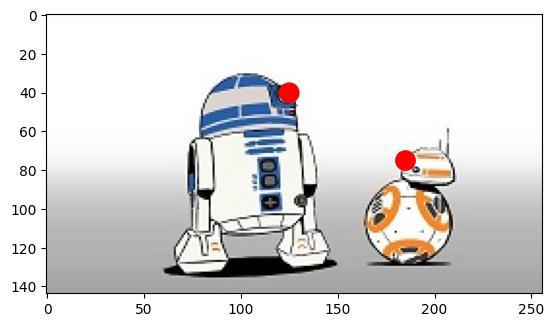

In [37]:
coords = torch.tensor([[[125, 40.0], [185.0, 75.0]]])  # BxNx2 [x,y]

fig, ax = plt.subplots()

ax.add_patch(plt.Circle((coords[0, 0, 0], coords[0, 0, 1]), color="r"))
ax.add_patch(plt.Circle((coords[0, 1, 0], coords[0, 1, 1]), color="r"))

ax.imshow(K.tensor_to_image(img))

# Crop image and points

None


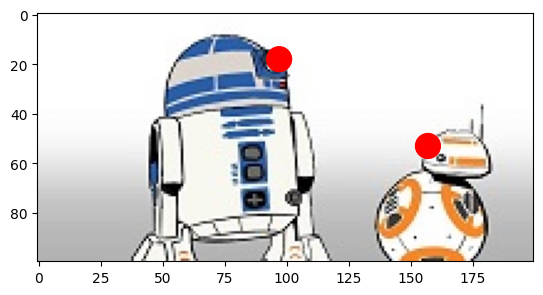

In [38]:
crop_op = K.augmentation.AugmentationSequential(K.augmentation.CenterCrop((100, 200)), data_keys=["input", "keypoints"])
print(crop_op.transform_matrix)

img_resize, coords_resize = crop_op(img, coords)


fig, ax = plt.subplots()

ax.add_patch(plt.Circle((coords_resize[0, 0, 0], coords_resize[0, 0, 1]), color="r"))
ax.add_patch(plt.Circle((coords_resize[0, 1, 0], coords_resize[0, 1, 1]), color="r"))

ax.imshow(K.tensor_to_image(img_resize))
plt.show()

None


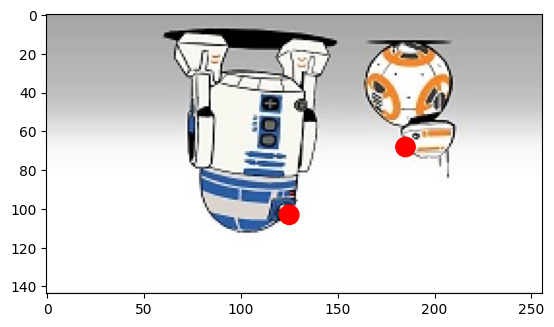

In [39]:
crop_op = K.augmentation.AugmentationSequential(K.augmentation.RandomVerticalFlip(p=1) , data_keys=["input", "keypoints"])
print(crop_op.transform_matrix)

img_resize, coords_resize = crop_op(img, coords)


fig, ax = plt.subplots()

ax.add_patch(plt.Circle((coords_resize[0, 0, 0], coords_resize[0, 0, 1]), color="r"))
ax.add_patch(plt.Circle((coords_resize[0, 1, 0], coords_resize[0, 1, 1]), color="r"))

ax.imshow(K.tensor_to_image(img_resize))
plt.show()

# BOXES AND KEYPOINTS AUGMENTATION

In [40]:
import io

import requests


def download_image(url: str, filename: str = "") -> str:
    filename = url.split("/")[-1] if len(filename) == 0 else filename
    # Download
    bytesio = io.BytesIO(requests.get(url).content)
    # Save file
    with open(filename, "wb") as outfile:
        outfile.write(bytesio.getbuffer())

    return filename


url = "https://raw.githubusercontent.com/kornia/data/main/panda.jpg"
download_image(url)

'panda.jpg'

In [41]:
import cv2
import kornia as K
import numpy as np
import torch
from kornia.augmentation import AugmentationSequential
from kornia.geometry import bbox_to_mask
from matplotlib import pyplot as plt

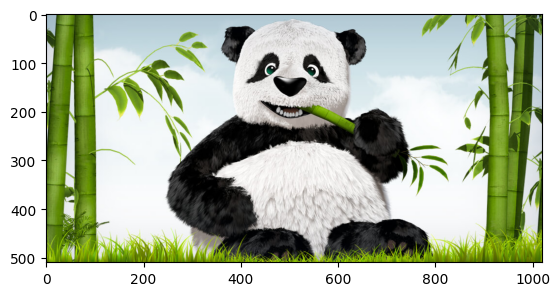

In [42]:
def plot_resulting_image(img, bbox, keypoints, mask):
    img = img * mask
    img_array = K.tensor_to_image(img.mul(255).byte()).copy()
    img_draw = cv2.polylines(img_array, bbox.numpy(), isClosed=True, color=(255, 0, 0))
    for k in keypoints[0]:
        img_draw = cv2.circle(img_draw, tuple(k.numpy()[:2]), radius=6, color=(255, 0, 0), thickness=-1)
    return img_draw


img_tensor = K.io.load_image("panda.jpg", K.io.ImageLoadType.RGB32)[None, ...]  # BxCxHxW
h, w = img_tensor.shape[-2:]

plt.imshow(K.tensor_to_image(img_tensor))
plt.show()

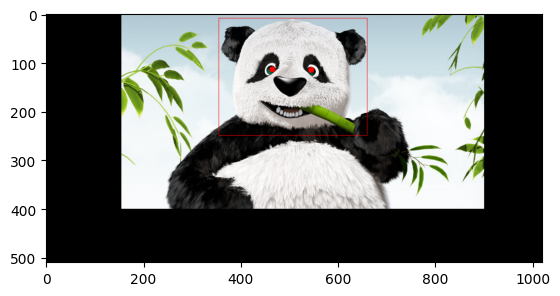

In [43]:
aug_list = AugmentationSequential(
    K.augmentation.Resize((int(h/4), int(w/4))),
    K.augmentation.ColorJitter(0.1, 0.1, 0.1, 0.1, p=1.0),
    K.augmentation.RandomHorizontalFlip(p=0.5),
    K.augmentation.RandomVerticalFlip(p=0.5),
    K.augmentation.RandomRotation(degrees=360, p=1.0),
    data_keys=["input", "bbox", "keypoints", "mask"],
    same_on_batch=False,
)

bbox = torch.tensor([[[[355, 10], [660, 10], [660, 250], [355, 250]]]])
keypoints = torch.tensor([[[465, 115], [545, 116]]])
mask = bbox_to_mask(torch.tensor([[[155, 0], [900, 0], [900, 400], [155, 400]]]), w, h)[None].float()

img_out = plot_resulting_image(img_tensor, bbox, keypoints, mask)

plt.imshow(img_out)
plt.show()

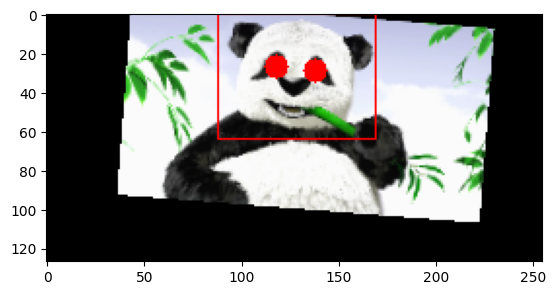

In [44]:
out_tensor = aug_list(img_tensor, bbox.float(), keypoints.float(), mask)
img_out = plot_resulting_image(
    out_tensor[0][0],
    out_tensor[1].int(),
    out_tensor[2].int(),
    out_tensor[3][0],
)

plt.imshow(img_out)
plt.show()